In [299]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from sklearn.metrics import auc
import json
from dateutil import relativedelta
from scipy import stats
import itertools as it
from matplotlib.ticker import LinearLocator
from matplotlib.ticker import FixedFormatter

In [42]:
def load_tsv(file):
    '''
    Loads replicates tsv as df.
    '''
    with open(file) as tfile:
        df = pd.read_csv(tfile, sep = '\t')
    return df

replicates = load_tsv('../results/replicates/replicate_mapping.tsv')
metadata = load_tsv('../results/metadata.tsv')

In [43]:
def load_snvs(file):
    '''
    Loads SNVs dictionary.
    '''
    with open(file) as jfile:
        snvs = json.load(jfile)
    return snvs

snvs_dict = load_snvs('../results/snvs.json')

In [44]:
exclude = [1,2,3,4,5,6,7,8,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,53,54]
replicates = replicates[~replicates.replicate_no.isin(exclude)]

In [316]:
def compare_frequencies(sDict, rDF, metadata, pileups):
    '''
    Creates dataframe containing the frequency of each sample variant in each pipeline
    '''
    replicates = []
    id1 = []
    id2 = []
    freq1 = []
    freq2 = []
    variants = []
    coverage1 = []
    coverage2 = []
    avg_ct = []
    reads1 = []
    reads2 = []
    type1 = []
    type2 = []
    avg_cov1 = []
    avg_cov2 = []
    for s1, s2, num in zip(rDF['id1'], rDF['id2'], rDF['replicate_no']):
        ct = metadata.loc[metadata.id == s1, 'avg_ct'].values[0]
        with open(pileups + s1 + '.pileup') as tfile:
            p1 = pd.read_csv(tfile, sep = '\t', header=None, nrows=29903)
        with open(pileups + s2 + '.pileup') as tfile:
            p2 = pd.read_csv(tfile, sep = '\t', header=None, nrows=29903)
        cov1 = p1.iloc[:,3].sum()/29903
        cov2 = p2.iloc[:,3].sum()/29903
        snvs1 = []
        snvs2 = []
        for c, p, v in zip(sDict[s1]['consensus'], sDict[s1]['position'], sDict[s1]['variant']):
            snvs1.append(c+str(p)+v)
        for c, p, v in zip(sDict[s2]['consensus'], sDict[s2]['position'], sDict[s2]['variant']):
            snvs2.append(c+str(p)+v)
        snvs = list(set(snvs1+snvs2))
        positions = [int(snv[1:-1]) for snv in snvs]
        for snv, pos in zip(snvs, positions):
            if snv in snvs1:
                i = snvs1.index(snv)
                freq1.append(sDict[s1]['frequency'][i])
                reads1.append(sDict[s1]['reads'][i])
                type1.append(sDict[s1]['type'][i])
            else:
                freq1.append(0)
                reads1.append(0)
                type1.append('None')
            if snv in snvs2:
                i = snvs2.index(snv)
                freq2.append(sDict[s2]['frequency'][i])
                reads2.append(sDict[s2]['reads'][i])
                type2.append(sDict[s2]['type'][i])
            else:
                freq2.append(0)
                reads2.append(0)
                type2.append('None')
            coverage1.append(p1.at[pos-1,3])
            coverage2.append(p2.iat[pos-1,3])
            id1.append(s1)
            id2.append(s2)
            avg_ct.append(ct)
            replicates.append(num)
            variants.append(snv)
            avg_cov1.append(cov1)
            avg_cov2.append(cov2)

    frequencies = pd.DataFrame({ 'id1':id1, 'id2':id2, 'replicate_no':replicates, 'freq1':freq1, 'freq2':freq2, 'snv':variants, 'coverage1':coverage1, 'coverage2':coverage2, 'reads1':reads1, 'reads2':reads2, 'avg_ct':avg_ct, 'type1':type1, 'type2':type2, 'avg_coverage1':avg_cov1, 'avg_coverage2':avg_cov2})
    return frequencies

variants = compare_frequencies(snvs_dict, replicates, metadata, '/fh/scratch/delete10/bedford_t/ncov_pileups/')

In [317]:
with open('../results/replicates/minor_variant_frequencies.tsv', 'w') as f:
    variants.to_csv(f, sep = '\t', index=False)

In [318]:
variants

,id1,id2,replicate_no,freq1,freq2,snv,coverage1,coverage2,reads1,reads2,avg_ct,type1,type2,avg_coverage1,avg_coverage2
0,20200511_fastq_401463,20210115_fastq_401463,10,0.011921,0.000000,C14708T,5872,603,70,0,27.583664,Alternate,None,5665.470655,598.574457
1,20200511_fastq_401463,20210115_fastq_401463,10,0.000000,0.018282,G23093T,6796,547,0,10,27.583664,None,Alternate,5665.470655,598.574457
2,20200511_fastq_401463,20210115_fastq_401463,10,0.000000,0.014493,G5012T,5001,759,0,11,27.583664,None,Alternate,5665.470655,598.574457
3,20200511_fastq_401463,20210115_fastq_401463,10,0.021015,0.000000,C23170T,6424,641,135,0,27.583664,Alternate,None,5665.470655,598.574457
4,20200511_fastq_401463,20210115_fastq_401463,10,0.000000,0.015601,T8136C,4719,641,0,10,27.583664,None,Alternate,5665.470655,598.574457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4104,20210115_fastq_501492,20210115_fastq_502599,77,0.043167,0.027401,C9502T,3776,3978,163,109,18.686825,Alternate,Alternate,3710.404073,4016.807879
4105,20210115_fastq_501492,20210115_fastq_502599,77,0.011302,0.000000,T25977C,3716,4989,42,0,18.686825,Alternate,None,3710.404073,4016.807879
4106,20210115_fastq_501492,20210115_fastq_502599,77,0.012642,0.000000,T13855C,3085,3449,39,0,18.686825,Alternate,None,3710.404073,4016.807879
4107,20210115_fastq_501492,20210115_fastq_502599,77,0.000000,0.010407,T5952C,3230,3363,0,35,18.686825,None,Alternate,3710.404073,4016.807879


In [27]:
def plot_histograms(df, output):
    '''
    Plots density histogram of snvs by Ct, coverage, frequency, # of reads.
    Colors by intersection snv vs. not.
    '''
    df = df[(df.coverage1 >= 100) & (df.coverage2 >= 100)].copy()
    intersect = []
    for freq1, freq2 in zip(df.freq1, df.freq2):
        if freq1 and freq2 > 0:
            intersect.append('yes')
        else:
            intersect.append('no')
    df['intersect'] = intersect
    df['lowest_cov'] = df[['coverage1','coverage2']].min(axis=1)
    df['max_freq'] = df[['freq1', 'freq2']].max(axis=1)
    df['max_reads'] = df[['reads1', 'reads2']].max(axis=1)

    #df = df[(df.max_freq > 0.03) & (df.max_reads > 10) & (df.avg_ct < 28)].copy()

    
    part1 = df[['intersect', 'reads1', 'freq1']].rename(columns={'reads1':'reads', 'freq1':'freq'})
    part2 = df[['intersect', 'reads2', 'freq2']].rename(columns={'reads2':'reads', 'freq2':'freq'})
    merged = part1.append(part2)
    merged = merged[(merged.freq) > 0]

    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))
    
    sns.histplot(df, x='avg_ct', hue='intersect', stat='count', element='step', ax=ax1, discrete=False, binwidth=1)
    ax1.set(ylabel='# of SNVs', xlabel='Average Ct')
    
    sns.histplot(merged, x='freq', hue='intersect', stat='count', element='step', ax=ax2, discrete=False, binwidth=0.005)
    ax2.set(ylabel='# of SNVs', xlabel='Frequency')  
    ax2z = plt.axes([0.65, 0.65, .18, .18])
    sns.histplot(merged, x='freq', hue='intersect', stat='count', element='step', ax=ax2z, discrete=False, legend=False, binwidth=0.005)
    ax2z.set_title('zoom')
    ax2z.set_xlim([0.005,0.1])
    ax2z.set_ylim([0,1000])
    #ax2z.set_yscale('log')
        
    sns.histplot(df, x='lowest_cov', hue='intersect', stat='count', element='step', ax=ax3, discrete=False, binwidth=25)
    ax3.set(ylabel='# of SNVs', xlabel='Coverage')
    ax3z = plt.axes([0.21, 0.23, .18, .18])
    sns.histplot(df, x='lowest_cov', hue='intersect', stat='count', element='step', ax=ax3z, discrete=False, legend=False, binwidth=25)
    ax3z.set_title('zoom')
    ax3z.set_xlim([0,4500])
    #ax3z.set_yscale('log')
    
    sns.histplot(merged, x='reads', hue='intersect', stat='count', element='step', ax=ax4, discrete=False, binwidth=5)
    ax4.set(ylabel='# of SNVs', xlabel='# of reads supporting SNV')
    ax4z = plt.axes([0.65, 0.23, .18, .18])
    sns.histplot(merged, x='reads', hue='intersect', stat='count', element='step', ax=ax4z, discrete=False, legend=False, binwidth=5)
    ax4z.set_title('zoom')
    ax4z.set_xlim([0,100])
    #ax4z.set_yscale('log')
    
    
    

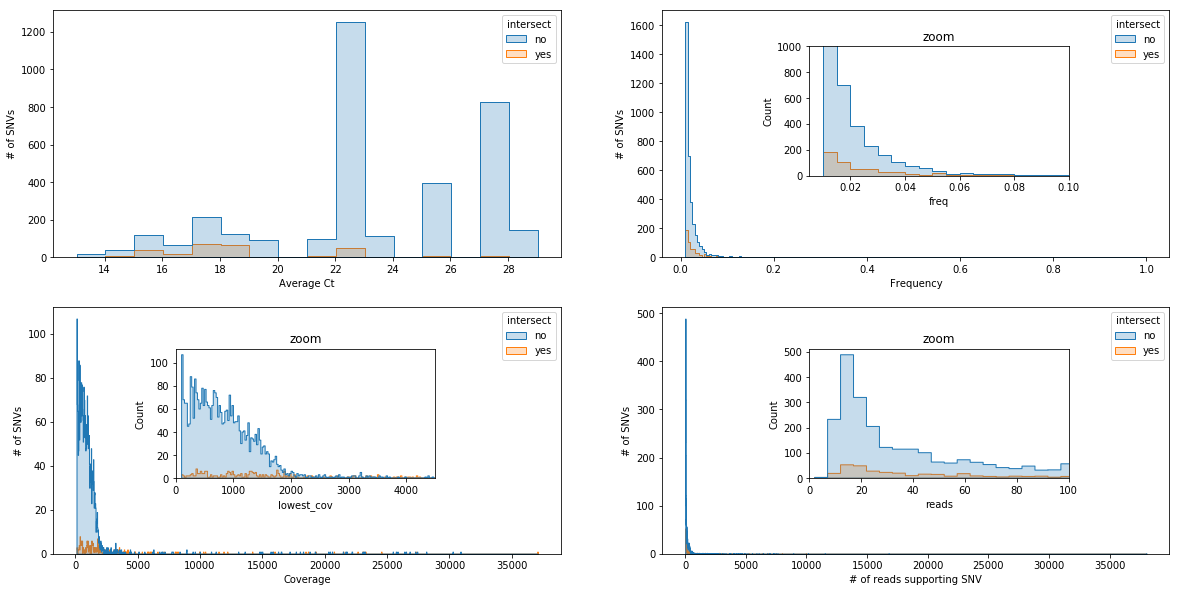

In [28]:
plot_histograms(variants, 'whatevs')

In [10]:
df = variants[(variants.coverage1 >= 100) & (variants.coverage2 >= 100)].copy()
df['max_freq'] = df[['freq1', 'freq2']].max(axis=1)

df = df[df.max_freq > 0.04].copy()
intersect = []
for freq1, freq2 in zip(df.freq1, df.freq2):
    if freq1 and freq2 > 0:
        intersect.append('yes')
    else:
        intersect.append('no')
df['intersect'] = intersect
df['lowest_cov'] = df[['coverage1','coverage2']].min(axis=1)
ct = [float(t[1:-1]) for t in df.avg_ct]
df['avg_ct'] = ct

part1 = df[['intersect', 'reads1', 'freq1', 'avg_ct']].rename(columns={'reads1':'reads', 'freq1':'freq'})
part2 = df[['intersect', 'reads2', 'freq2', 'avg_ct']].rename(columns={'reads2':'reads', 'freq2':'freq'})
merged = part1.append(part2)
merged = merged[merged.freq>0]

ax = sns.jointplot(data=merged, x='reads', y = 'freq', hue='intersect')
#ax.set_xlim([20,30])
#ax.set_ylim(0,2000)
#ax1.set(ylabel='# of SNVs', xlabel='Average Ct')



TypeError: 'float' object is not subscriptable

# Specificity & sensitivity of threshholds

In [425]:
def clean_variants(df):
    df = df[(df.coverage1 >= 100) & (df.coverage2 >= 100)].copy()
    intersect = []
    for freq1, freq2 in zip(df.freq1, df.freq2):
        if freq1 and freq2 > 0:
            intersect.append('yes')
        else:
            intersect.append('no')
    df['intersect'] = intersect
    df['lowest_cov'] = df[['coverage1','coverage2']].min(axis=1)
    df['max_freq'] = df[['freq1', 'freq2']].max(axis=1)
    df['max_reads'] = df[['reads1', 'reads2']].max(axis=1)
    df = df[(df.max_freq <= 0.5) & (df.max_freq >= 0.01)].copy()
    df = df[df.max_reads > 10].copy()
    df = df[df.lowest_cov >= 100].copy()
    df = df[(df.replicate_no < 20) | (df.replicate_no > 57)]
    return df

cleaned = clean_variants(variants)

In [426]:
cleaned

,id1,id2,replicate_no,freq1,freq2,snv,coverage1,coverage2,reads1,reads2,avg_ct,type1,type2,avg_coverage1,avg_coverage2,intersect,lowest_cov,max_freq,max_reads
0,20200511_fastq_401463,20210115_fastq_401463,10,0.011921,0.000000,C14708T,5872,603,70,0,27.583664,Alternate,None,5665.470655,598.574457,no,603,0.011921,70
2,20200511_fastq_401463,20210115_fastq_401463,10,0.000000,0.014493,G5012T,5001,759,0,11,27.583664,None,Alternate,5665.470655,598.574457,no,759,0.014493,11
3,20200511_fastq_401463,20210115_fastq_401463,10,0.021015,0.000000,C23170T,6424,641,135,0,27.583664,Alternate,None,5665.470655,598.574457,no,641,0.021015,135
5,20200511_fastq_401463,20210115_fastq_401463,10,0.037297,0.000000,A5169C,4424,862,165,0,27.583664,Alternate,None,5665.470655,598.574457,no,862,0.037297,165
6,20200511_fastq_401463,20210115_fastq_401463,10,0.010153,0.000000,T13331C,5023,898,51,0,27.583664,Alternate,None,5665.470655,598.574457,no,898,0.010153,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4104,20210115_fastq_501492,20210115_fastq_502599,77,0.043167,0.027401,C9502T,3776,3978,163,109,18.686825,Alternate,Alternate,3710.404073,4016.807879,yes,3776,0.043167,163
4105,20210115_fastq_501492,20210115_fastq_502599,77,0.011302,0.000000,T25977C,3716,4989,42,0,18.686825,Alternate,None,3710.404073,4016.807879,no,3716,0.011302,42
4106,20210115_fastq_501492,20210115_fastq_502599,77,0.012642,0.000000,T13855C,3085,3449,39,0,18.686825,Alternate,None,3710.404073,4016.807879,no,3085,0.012642,39
4107,20210115_fastq_501492,20210115_fastq_502599,77,0.000000,0.010407,T5952C,3230,3363,0,35,18.686825,None,Alternate,3710.404073,4016.807879,no,3230,0.010407,35


In [427]:
def calc_sens_spec(df, var, thresh):
    '''
    Given variable and threshold, returns sensitivity & specificity for calling SNVs. 
    '''
    if var == 'avg_ct':
        below = df[df[var] > thresh]
        above = df[df[var] <= thresh]
    else:
        below = df[df[var] < thresh]
        above = df[df[var] >= thresh]
    tp = len(above[above.intersect == 'yes'])
    fp = len(above[above.intersect == 'no'])
    fn = len(below[below.intersect == 'yes'])
    tn = len(below[below.intersect == 'no'])
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)
    return sens, spec

In [428]:
def generate_sens_spec(df, var, threshold):
    '''
    Returns df containing sensitivity & specificity at each threshold for variable.
    '''
    sensitivity = []
    specificity = []
    variable = []
    for t in threshold:
        sens, spec = calc_sens_spec(df, var, t)
        sensitivity.append(sens)
        specificity.append(spec)
        variable.append(t)
    df = pd.DataFrame()
    df[var] = variable
    df['sensitivity'] = sensitivity
    df['specificity'] = specificity
    df['fpr'] = 1 - df['specificity']
    df['youden'] = df['sensitivity'] + df['specificity'] - 1
    return df
        

In [429]:
freq = np.arange(0.010, 0.201, 0.001)
ct = np.arange(10, 28.4, 0.05)
reads = np.arange(10, 40002, 2)
cov = np.arange(100, 5010, 10)
ct_cleaned = cleaned.dropna(subset = ['avg_ct'])

In [430]:
freq_df = generate_sens_spec(cleaned, 'max_freq', freq)
ct_df = generate_sens_spec(ct_cleaned, 'avg_ct', ct)
reads_df = generate_sens_spec(cleaned, 'max_reads', reads)
cov_df = generate_sens_spec(cleaned, 'lowest_cov', cov)

In [431]:
def plot_sens_spec(ct_df, freq_df, cov_df, reads_df):
    '''
    Plots sensitivity & specificity for variables.
    '''
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))
    
    sns.lineplot(data=ct_df, x='avg_ct', y='sensitivity', ax=ax1, label='sensitivity', linewidth=2)
    ax1b=ax1.twinx()
    sns.lineplot(data=ct_df, x='avg_ct', y='specificity', color='red', ax=ax1b, label='specificity', linewidth=2)
    ax1.set(xlabel='Average Ct')
    ax1.set_ylim([0,1])
    ax1b.set_ylim([0,1])
    ax1.invert_xaxis()
    ax1b.legend(loc='center', bbox_to_anchor=(2.4, 0))
    ax1.legend(loc='center', bbox_to_anchor=(2.4, -0.1))
    ax1.grid(linestyle='dashed')
    ax1.set_xlim([max(ct_df['avg_ct']), 20])
    
    sns.lineplot(data=freq_df, x='max_freq', y='sensitivity', ax=ax2, linewidth=2)
    ax2b=ax2.twinx()
    sns.lineplot(data=freq_df, x='max_freq', y='specificity', color='red', ax=ax2b, linewidth=2)
    ax2.set(xlabel='Frequency')
    ax2.set_ylim([0,1])
    ax2b.set_ylim([0,1])
    ax2.grid(linestyle='dashed')
    ax2.set_xlim([0, 0.1])

    
    sns.lineplot(data=cov_df, x='lowest_cov', y='sensitivity', ax=ax3, linewidth=2)
    ax3b=ax3.twinx()
    sns.lineplot(data=cov_df, x='lowest_cov', y='specificity', color='red', ax=ax3b, linewidth=2)
    ax3.set(xlabel='Coverage')
    ax3.set_ylim([0,1])
    ax3b.set_ylim([0,1])
    ax3.grid(linestyle='dashed')
    ax3.set_xlim([0, 1500])
    
    sns.lineplot(data=reads_df, x='max_reads', y='sensitivity', ax=ax4, linewidth=2)
    ax4b=ax4.twinx()
    sns.lineplot(data=reads_df, x='max_reads', y='specificity', color='red', ax=ax4b, linewidth=2)
    ax4.set(xlabel='Minimum reads per SNV')
    ax4.set_ylim([0,1])
    ax4b.set_ylim([0,1])
    ax4.grid(linestyle='dashed')
    ax4.set_xlim([0,200])



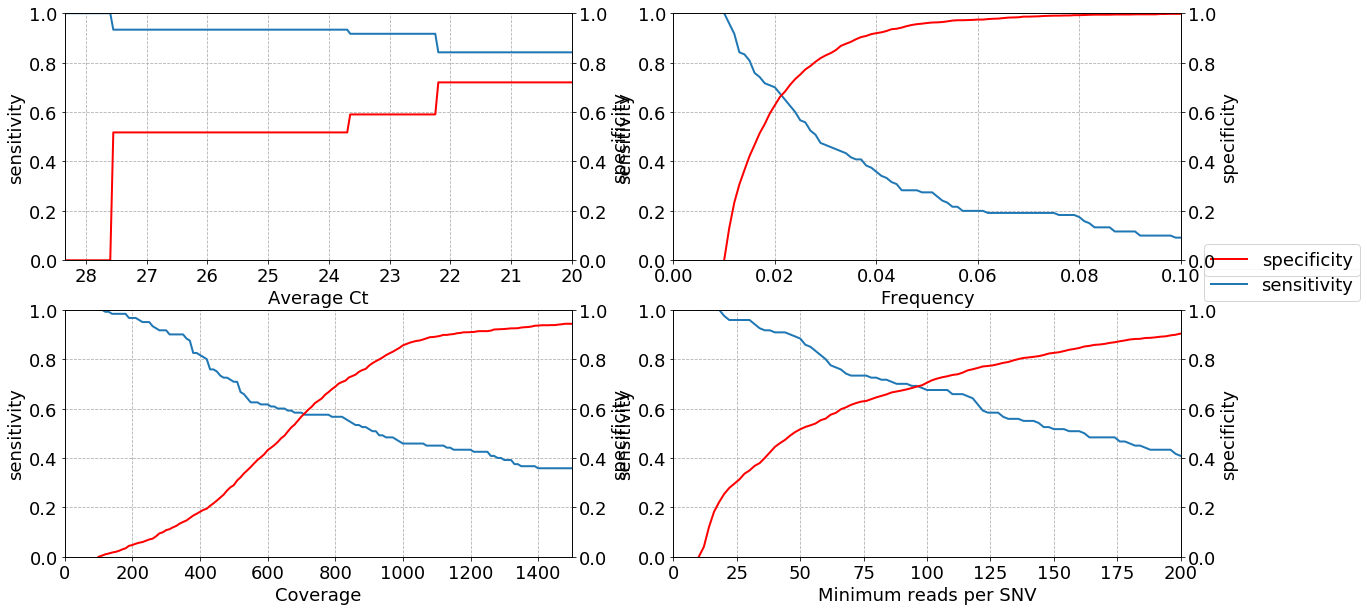

In [432]:
plot_sens_spec(ct_df, freq_df, cov_df, reads_df)

In [433]:
def plot_roc(freq_df, reads_df, cov_df, ct_df):
    '''
    Plots ROC curve
    '''
    youden_freq = freq_df['max_freq'][freq_df['youden'].idxmax()]
    youden_tpr = freq_df['sensitivity'][freq_df['youden'].idxmax()]
    youden_fpr = freq_df['fpr'][freq_df['youden'].idxmax()]
    mpl.rcParams.update({'font.size': 18})
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
    
    
    for df, col, label in zip([freq_df, reads_df, cov_df, ct_df], ['#8338EC', '#3A86FF','#FF006E','#FFBE0B'], ['Frequency', 'Reads per SNV', 'Coverage', 'Average Ct']):
        AUC = "{:.2f}".format(auc(df['fpr'], df['sensitivity']))
        sns.lineplot(data=df, x='fpr', y='sensitivity', ax=ax1, color=col, label=(label + '; AUC=' + AUC), linewidth=2)
        ax1.set(ylabel='True positive rate = Sensitivity', xlabel = 'False positive rate = 1 - Specificity')
    ax1.plot(ax1.get_xlim(), ax1.get_ylim(), ls="--", c=".3")
    ax1.grid(linestyle='dashed')
    ax1.legend()
    #ax1.vlines(x=youden_fpr, ymin=youden_fpr, ymax=youden_tpr, colors='black', linestyle='dotted')

    sns.lineplot(data=freq_df, x='max_freq', y='sensitivity', ax=ax2, linewidth=2, label='Sensitivity')
    ax2b=ax2.twinx()
    sns.lineplot(data=freq_df, x='max_freq', y='specificity', color='red', ax=ax2b, linewidth=2, label='Specificity')
    ax2.set(xlabel='Frequency', ylabel='Sensitivity')
    ax2b.set(ylabel='Specificity')
    ax2.set_ylim([0,1])
    ax2b.set_ylim([0,1])
    ax2.grid(linestyle='dashed')
    ax2.set_xlim([0, 0.1])
    ax2.axvline(x=youden_freq, c='black', ls='--')
    ax2b.legend(loc='center', bbox_to_anchor=(0.8, 0.8))
    ax2.legend(loc='center', bbox_to_anchor=(0.8, 0.7))
    ax2.text(x=0.0375, y=0.1, s='Maximum Youden Index:', fontsize=18, fontweight='bold')
    ax2.text(x=0.063, y=0.045, s='Freq={:.3f}'.format(youden_freq), fontsize=18, fontweight='bold')
    
    return plt.show()





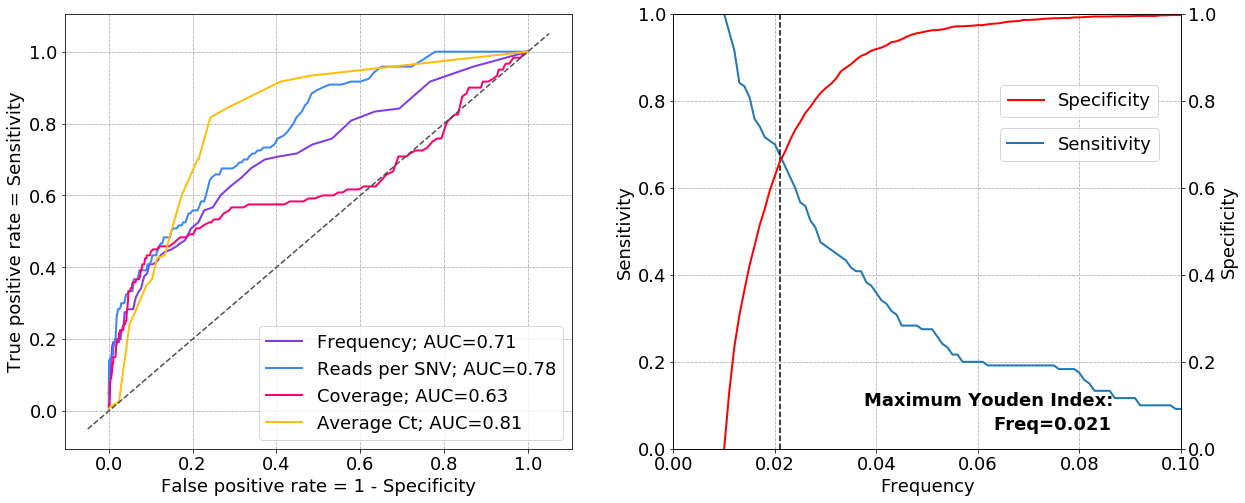

In [434]:
plot_roc(freq_df, reads_df, cov_df, ct_df)

In [435]:
def get_youden(freq_df, reads_df, ct_df, cov_df):
    youden_freq = freq_df['max_freq'][freq_df['youden'].idxmax()]
    youden_reads = reads_df['max_reads'][reads_df['youden'].idxmax()]
    youden_cov = cov_df['lowest_cov'][cov_df['youden'].idxmax()]
    youden_ct = ct_df['avg_ct'][ct_df['youden'].idxmax()]
    
    print('Youden Index cutoffs:')
    print('Frequency={:.3f}'.format(youden_freq))
    print('Reads=' + str(youden_reads))
    print('Coverage=' +str(youden_cov))
    print('Ct={:.2f}'.format(youden_ct))

get_youden(freq_df, reads_df, ct_df, cov_df)

Youden Index cutoffs:
Frequency=0.021
Reads=108
Coverage=1120
Ct=18.70


In [436]:
def plot_roc(freq_df, reads_df, cov_df, ct_df):
    '''
    Plots ROC curve
    '''
    youden_freq = freq_df['max_freq'][freq_df['youden'].idxmax()]
    youden_reads = reads_df['max_reads'][reads_df['youden'].idxmax()]
    youden_cov = cov_df['lowest_cov'][cov_df['youden'].idxmax()]
    youden_ct = ct_df['avg_ct'][ct_df['youden'].idxmax()]
    
    
    mpl.rcParams.update({'font.size': 18})
    
    fig, ax1 = plt.subplots(figsize=(10,8))
    
    
    for df, col, label, text in zip([freq_df, reads_df, cov_df, ct_df], ['#8338EC', '#3A86FF','#FF006E','#FFBE0B'], ['Frequency', 'Reads per SNV', 'Coverage', 'Average Ct'], [youden_freq, youden_reads, youden_cov, youden_ct]):
        AUC = "{:.2f}".format(auc(df['fpr'], df['sensitivity']))
        sns.lineplot(data=df, x='fpr', y='sensitivity', ax=ax1, color=col, label=(label + '; AUC=' + AUC), linewidth=2)
        youden_tpr = df['sensitivity'][df['youden'].idxmax()]
        youden_fpr = df['fpr'][df['youden'].idxmax()]
        ax1.scatter(x=youden_fpr, y=youden_tpr, color=col, s=75)
    ax1.set(ylabel='True positive rate = Sensitivity', xlabel = 'False positive rate = 1 - Specificity')
    ax1.plot(ax1.get_xlim(), ax1.get_ylim(), ls="--", c=".3")
    ax1.grid(linestyle='dashed')
    ax1.legend()
    ax1.text(x=0, y=1, s='Maximum Youden Index:', fontsize=14)
    ax1.text(x=0.3, y=0.55, s='Freq={:.3f}'.format(youden_freq), fontsize=10)
    ax1.text(x=0.43, y=0.81, s='Reads={:.0f}'.format(youden_reads), fontsize=10)
    ax1.text(x=0.15, y=0.6, s='Cov={:.0f}'.format(youden_cov), fontsize=10)
    ax1.text(x=0.1, y=0.75, s='Ct={:.2f}'.format(youden_ct), fontsize=10)

    #ax1.vlines(x=youden_fpr, ymin=youden_fpr, ymax=youden_tpr, colors='black', linestyle='dotted')
    
    return plt.show()

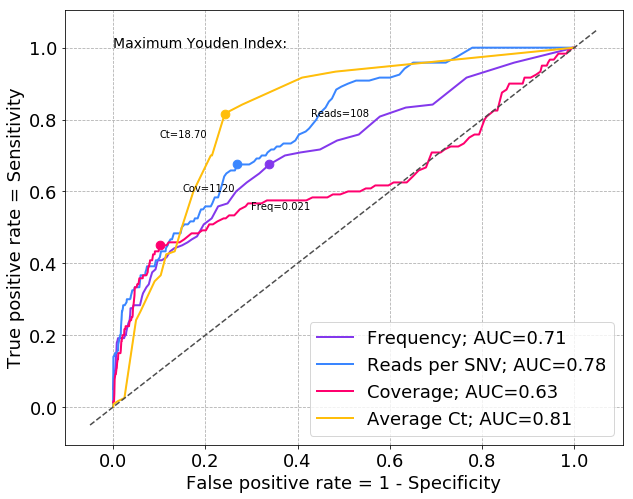

In [437]:
plot_roc(freq_df, reads_df, cov_df, ct_df)

## ROC for multiple parameters

In [438]:
def calc_sens_spec(df, var1, var2, thresh1, thresh2):
    '''
    Given variable and threshold, returns sensitivity & specificity for calling SNVs. 
    '''
    if var1 == 'avg_ct':
        below = df[(df[var1] > thresh1) | (df[var2] < thresh2)]
        above = df[(df[var1] <= thresh1) & (df[var2] >= thresh2)]
    elif var2 == 'avg_ct':
        below = df[(df[var2] > thresh2) | (df[var1] < thresh1)]
        above = df[(df[var2] <= thresh2) & (df[var1] >= thresh1)]
    else:   
        below = df[(df[var1] < thresh1) | (df[var2] < thresh2)]
        above = df[(df[var1] >= thresh1) & (df[var2] >= thresh2)]
    tp = len(above[above.intersect == 'yes'])
    fp = len(above[above.intersect == 'no'])
    fn = len(below[below.intersect == 'yes'])
    tn = len(below[below.intersect == 'no'])
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)
    return sens, spec

def generate_sens_spec(df, var, thresholds):
    '''
    Returns df containing sensitivity & specificity at each threshold for variable.
    '''
    sensitivity = []
    specificity = []
    variable1 = []
    variable2 = []
    for (t1, t2) in it.product(thresholds[0], thresholds[1]):
        sens, spec = calc_sens_spec(df, var[0], var[1], t1, t2)
        sensitivity.append(sens)
        specificity.append(spec)
        variable1.append(t1)
        variable2.append(t2)
    result = pd.DataFrame()
    result[var[0]] = variable1
    result[var[1]] = variable2
    result['sensitivity'] = sensitivity
    result['specificity'] = specificity
    result['fpr'] = 1 - result['specificity']
    result['youden'] = result['sensitivity'] + result['specificity'] - 1
    return result

In [439]:
freq_test = np.arange(0.010, 0.101, 0.001)
cov_test = np.arange(100, 2010, 10)
ct_test = np.arange(10, 28.4, 0.05)


In [440]:
cov_freq_df = generate_sens_spec(cleaned, ['lowest_cov', 'max_freq'], [cov_test, freq_test])
cov_ct_df = generate_sens_spec(cleaned, ['lowest_cov', 'avg_ct'], [cov_test, ct_test])
freq_ct_df = generate_sens_spec(cleaned, ['max_freq', 'avg_ct'], [freq_test, ct_test])

In [441]:
dedup = cov_freq_df.sort_values(by=['sensitivity'], ascending=False).drop_duplicates(subset=['specificity'], keep='first')
dedup_ct = cov_ct_df.sort_values(by=['sensitivity'], ascending=False).drop_duplicates(subset=['specificity'], keep='first')
dedup_ct_freq = freq_ct_df.sort_values(by=['sensitivity'], ascending=False).drop_duplicates(subset=['specificity'], keep='first')

In [442]:
cov_ct_df

,lowest_cov,avg_ct,sensitivity,specificity,fpr,youden
0,100,10.00,0.00,1.000000,0.000000,0.000000
1,100,10.05,0.00,1.000000,0.000000,0.000000
2,100,10.10,0.00,1.000000,0.000000,0.000000
3,100,10.15,0.00,1.000000,0.000000,0.000000
4,100,10.20,0.00,1.000000,0.000000,0.000000
...,...,...,...,...,...,...
70283,2000,28.15,0.25,0.958306,0.041694,0.208306
70284,2000,28.20,0.25,0.958306,0.041694,0.208306
70285,2000,28.25,0.25,0.958306,0.041694,0.208306
70286,2000,28.30,0.25,0.958306,0.041694,0.208306


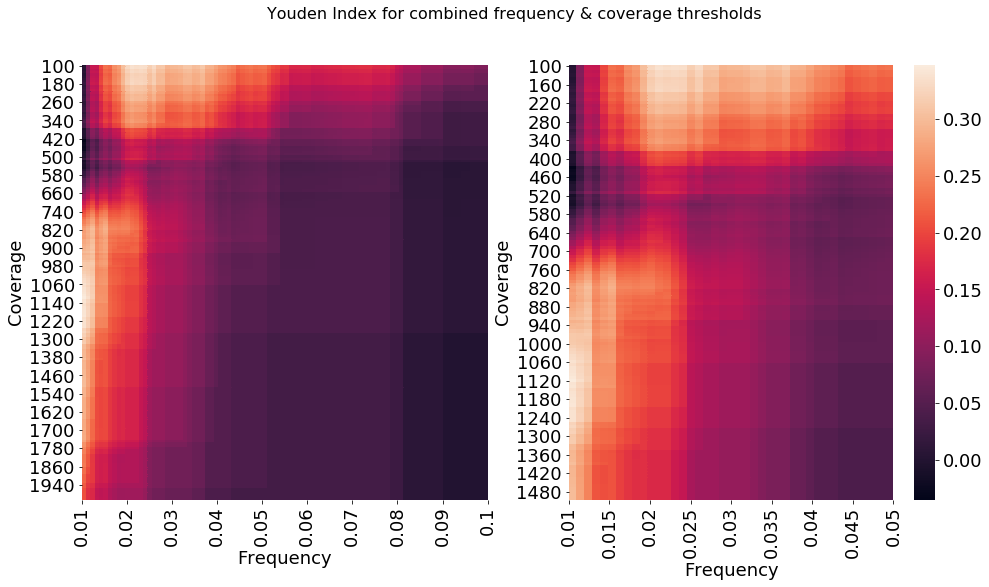

In [443]:
def plot_heatmap(df, var1, var2):
    '''
    Plots Youden index for two variables
    '''
    ticks1 = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10]
    ticks2 = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]
    table = df.pivot(var1, var2, 'youden')
    _min = min(df['youden'])
    _max = max(df['youden'])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
    sns.heatmap(table, ax=ax1, vmin = _min, vmax = _max, cbar=False, xticklabels = ticks1)
    ax1.xaxis.set_major_locator(LinearLocator(10))
    ax1.set(ylabel='Coverage', xlabel='Frequency')

    
    df_shrunk = df[(df[var1] <= 1500) & (df[var2] <= 0.05)]
    table_shrunk = df_shrunk.pivot(var1, var2, 'youden')
    sns.heatmap(table_shrunk, ax=ax2, vmin = _min, vmax = _max, xticklabels = ticks2)
    ax2.xaxis.set_major_locator(LinearLocator(9))
    ax2.set(ylabel='Coverage', xlabel='Frequency')
    fig.suptitle('Youden Index for combined frequency & coverage thresholds', fontsize=16)
    return plt.show()
    
plot_heatmap(cov_freq_df, 'lowest_cov', 'max_freq')
    
# TO DO: Keep color scale same for both plots. Check out average of 

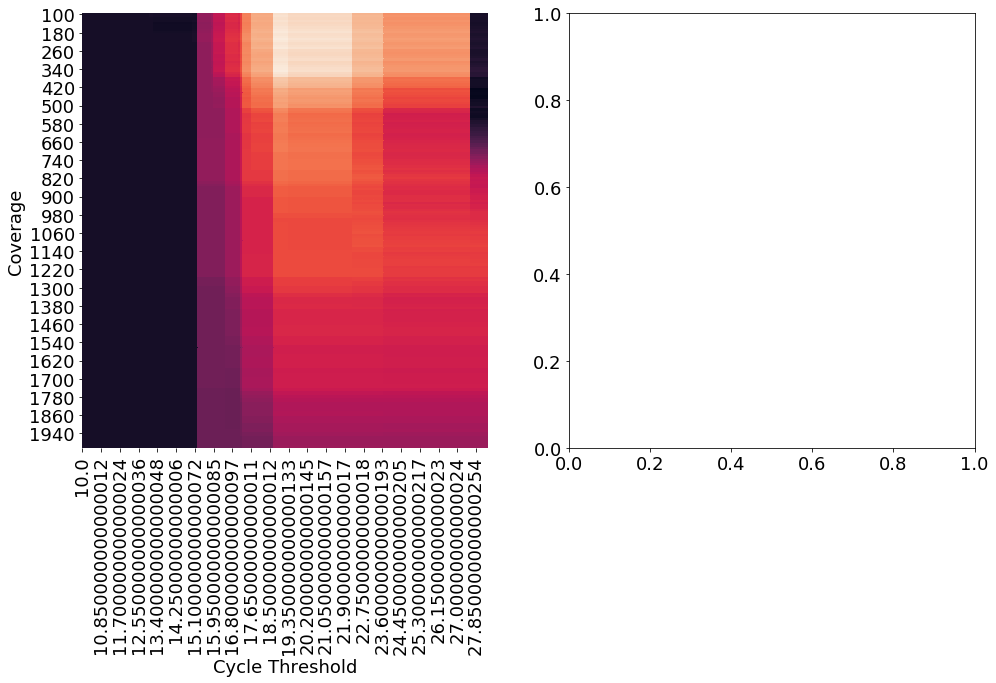

In [444]:
def plot_heatmap(df, var1, var2):
    '''
    Plots Youden index for two variables
    '''
    #ticks1 = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10]
    #ticks2 = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]
    table = df.pivot(var1, var2, 'youden')
    _min = min(df['youden'])
    _max = max(df['youden'])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
    sns.heatmap(table, ax=ax1, vmin = _min, vmax = _max, cbar=False)# xticklabels = ticks1)
    #ax1.xaxis.set_major_locator(LinearLocator(10))
    ax1.set(ylabel='Coverage', xlabel='Cycle Threshold')

    
    #df_shrunk = df[(df[var1] <= 1500) & (df[var2] <= 0.05)]
    #table_shrunk = df_shrunk.pivot(var1, var2, 'youden')
    #sns.heatmap(table_shrunk, ax=ax2, vmin = _min, vmax = _max)# xticklabels = ticks2)
    #ax2.xaxis.set_major_locator(LinearLocator(9))
    #ax2.set(ylabel='Coverage', xlabel='Cycle Threshold')
    #fig.suptitle('Youden Index for combined frequency & Ct thresholds', fontsize=16)
    return plt.show()
    
plot_heatmap(cov_ct_df, 'lowest_cov', 'avg_ct')

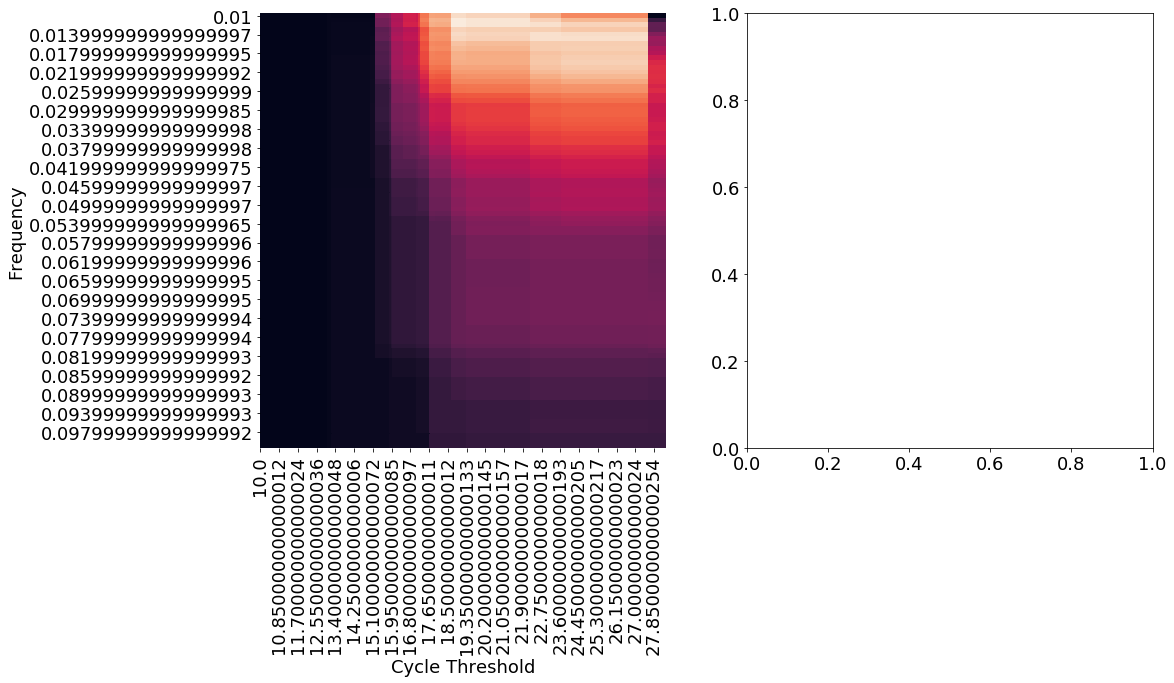

In [447]:
def plot_heatmap(df, var1, var2):
    '''
    Plots Youden index for two variables
    '''
    #ticks1 = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10]
    #ticks2 = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]
    table = df.pivot(var1, var2, 'youden')
    _min = min(df['youden'])
    _max = max(df['youden'])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
    sns.heatmap(table, ax=ax1, vmin = _min, vmax = _max, cbar=False)# xticklabels = ticks1)
    #ax1.xaxis.set_major_locator(LinearLocator(10))
    ax1.set(ylabel='Frequency', xlabel='Cycle Threshold')

    
    #df_shrunk = df[(df[var1] <= 1500) & (df[var2] <= 0.05)]
    #table_shrunk = df_shrunk.pivot(var1, var2, 'youden')
    #sns.heatmap(table_shrunk, ax=ax2, vmin = _min, vmax = _max)# xticklabels = ticks2)
    #ax2.xaxis.set_major_locator(LinearLocator(9))
    #ax2.set(ylabel='Coverage', xlabel='Cycle Threshold')
    #fig.suptitle('Youden Index for combined frequency & Ct thresholds', fontsize=16)
    return plt.show()
    
plot_heatmap(freq_ct_df, 'max_freq', 'avg_ct')

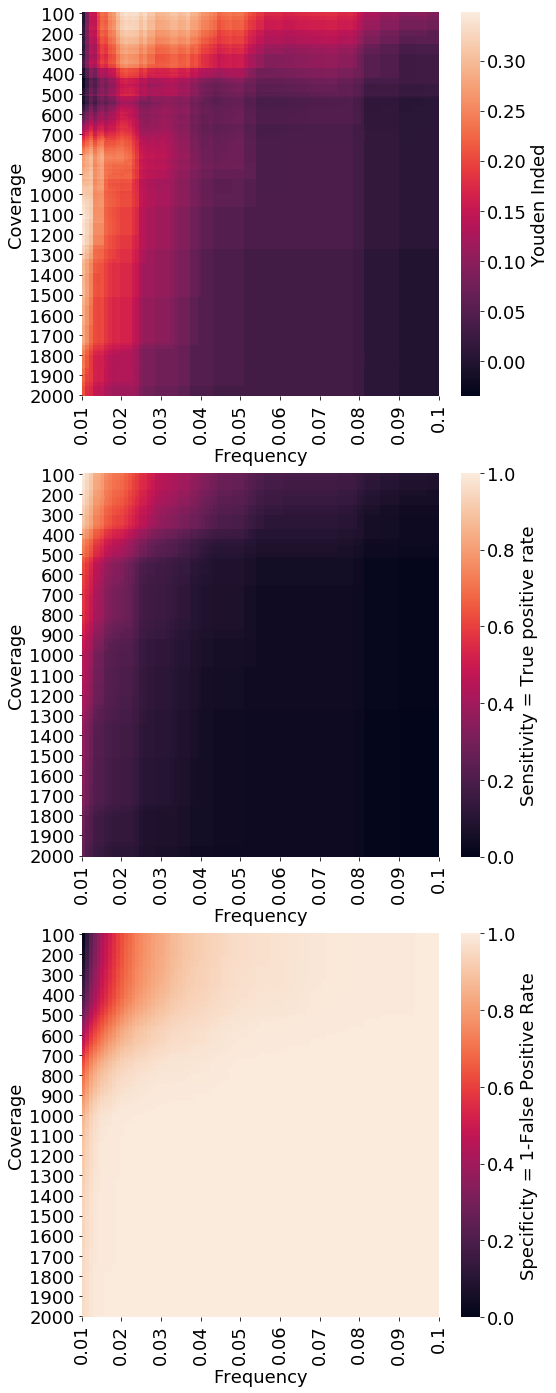

In [445]:
def plot_heatmap(df, var1, var2):
    '''
    Plots Youden index for two variables
    '''
    ticks1 = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10]
    
    youden_table = df.pivot(var1, var2, 'youden')
    
    tpr_table = df.pivot(var1, var2, 'sensitivity')
    
    specificity_table = df.pivot(var1, var2, 'specificity')
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,24))
    sns.heatmap(youden_table, ax=ax1, xticklabels = ticks1, cbar_kws={'label': 'Youden Inded'})
    sns.heatmap(tpr_table, ax=ax2, xticklabels = ticks1, cbar_kws={'label': 'Sensitivity = True positive rate'})
    sns.heatmap(specificity_table,ax=ax3, xticklabels=ticks1, cbar_kws={'label': 'Specificity = 1-False Positive Rate'})
    ax1.xaxis.set_major_locator(LinearLocator(10))
    ax1.set(ylabel='Coverage', xlabel='Frequency')
    ax2.xaxis.set_major_locator(LinearLocator(10))
    ax2.set(ylabel='Coverage', xlabel='Frequency')
    ax3.xaxis.set_major_locator(LinearLocator(10))
    ax3.set(ylabel='Coverage', xlabel='Frequency')
    return plt.show()
    
plot_heatmap(cov_freq_df, 'lowest_cov', 'max_freq')

In [446]:
cov_freq_df[(cov_freq_df['max_freq'] <= 0.026) & (cov_freq_df['max_freq'] > 0.02) & (cov_freq_df['lowest_cov'] > 540)]

,lowest_cov,max_freq,sensitivity,specificity,fpr,youden
4151,550,0.021,0.300000,0.819325,0.180675,0.119325
4152,550,0.022,0.283333,0.834547,0.165453,0.117880
4153,550,0.023,0.258333,0.853077,0.146923,0.111411
4154,550,0.024,0.233333,0.866976,0.133024,0.100309
4155,550,0.025,0.200000,0.878226,0.121774,0.078226
...,...,...,...,...,...,...
17492,2000,0.022,0.116667,1.000000,0.000000,0.116667
17493,2000,0.023,0.116667,1.000000,0.000000,0.116667
17494,2000,0.024,0.108333,1.000000,0.000000,0.108333
17495,2000,0.025,0.083333,1.000000,0.000000,0.083333


### What's the coverage of these typically?

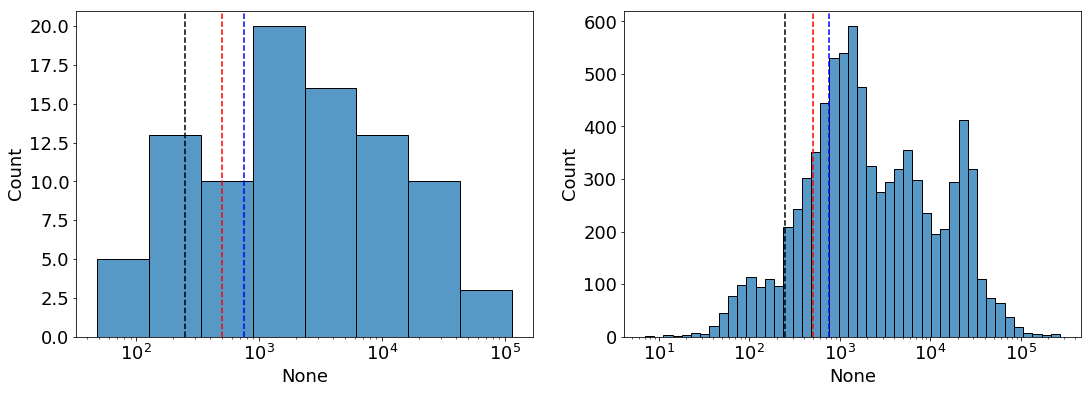

In [324]:
def plot_coverage(vDF):
    '''
    Filters to intersection SNPs and adds time since symptom onset for all.
    '''
    deduped = vDF[['id1', 'id2', 'avg_coverage1', 'avg_coverage2']].drop_duplicates()
    sample1 = deduped[['id1', 'avg_coverage1']].drop_duplicates()
    sample2 = deduped[['id2', 'avg_coverage2']].drop_duplicates()
    avg_coverage = list(sample1['avg_coverage1']) + list(sample2['avg_coverage2'])
    coverage = list(vDF['coverage1']) + list(vDF['coverage2'])

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
    sns.histplot(avg_coverage, ax=ax1, log_scale=True)
    sns.histplot(coverage, ax=ax2, log_scale=True)
    ax1.axvline(250, c='black', ls='--')
    ax1.axvline(500, c='red', ls='--')
    ax1.axvline(750, c='blue', ls='--')
    ax2.axvline(250, c='black', ls='--')
    ax2.axvline(500, c='red', ls='--')
    ax2.axvline(750, c='blue', ls='--')

    return plt.show()

plot_coverage(variants)

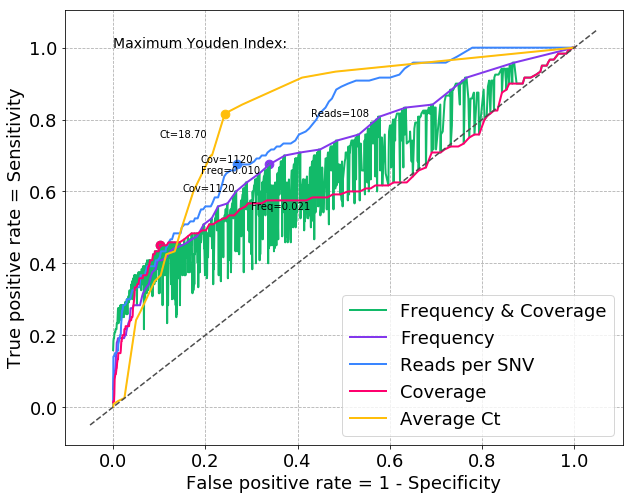

In [448]:
def plot_roc(freq_df, reads_df, cov_df, ct_df, cov_freq_df):
    '''
    Plots ROC curve
    '''
    youden_freq = freq_df['max_freq'][freq_df['youden'].idxmax()]
    youden_reads = reads_df['max_reads'][reads_df['youden'].idxmax()]
    youden_cov = cov_df['lowest_cov'][cov_df['youden'].idxmax()]
    youden_ct = ct_df['avg_ct'][ct_df['youden'].idxmax()]
    youden_combined_cov = cov_freq_df['lowest_cov'][cov_freq_df['youden'].idxmax()]
    youden_combined_freq = cov_freq_df['max_freq'][cov_freq_df['youden'].idxmax()]
    
    
    mpl.rcParams.update({'font.size': 18})
    
    fig, ax1 = plt.subplots(figsize=(10,8))
    
    
    for df, col, label, in zip([cov_freq_df, freq_df, reads_df, cov_df, ct_df], ['#12BA69', '#8338EC', '#3A86FF','#FF006E','#FFBE0B'], ['Frequency & Coverage', 'Frequency', 'Reads per SNV', 'Coverage', 'Average Ct']):
        #AUC = "{:.2f}".format(auc(df['fpr'], df['sensitivity']))
        sns.lineplot(data=df, x='fpr', y='sensitivity', ax=ax1, color=col, label=(label), linewidth=2)# + '; AUC=' + AUC), linewidth=2)
        youden_tpr = df['sensitivity'][df['youden'].idxmax()]
        youden_fpr = df['fpr'][df['youden'].idxmax()]
        ax1.scatter(x=youden_fpr, y=youden_tpr, color=col, s=75)
    ax1.set(ylabel='True positive rate = Sensitivity', xlabel = 'False positive rate = 1 - Specificity')
    ax1.plot(ax1.get_xlim(), ax1.get_ylim(), ls="--", c=".3")
    ax1.grid(linestyle='dashed')
    
    ax1.text(x=0, y=1, s='Maximum Youden Index:', fontsize=14)
    ax1.text(x=0.3, y=0.55, s='Freq={:.3f}'.format(youden_freq), fontsize=10)
    ax1.text(x=0.43, y=0.81, s='Reads={:.0f}'.format(youden_reads), fontsize=10)
    ax1.text(x=0.15, y=0.6, s='Cov={:.0f}'.format(youden_cov), fontsize=10)
    ax1.text(x=0.1, y=0.75, s='Ct={:.2f}'.format(youden_ct), fontsize=10)
    ax1.text(x=0.19, y=0.65, s = 'Freq={:.3f}'.format(youden_combined_freq), fontsize=10)
    ax1.text(x=0.19, y=0.68, s='Cov={:.0f}'.format(youden_combined_cov), fontsize=10)
    
    #for cutoff, col, in zip([300,800], ['#95D5B2', '#1B4332']):
     #   df = cov_freq_df[cov_freq_df['lowest_cov'] == cutoff]
      #  youden_freq = df['max_freq'][df['youden'].idxmax()]
       # AUC = "{:.2f}".format(auc(df['fpr'], df['sensitivity']))
        #sns.lineplot(data=df, x='fpr', y='sensitivity', ax=ax1, color=col, label=('Frequency at cov=' + str(cutoff) + '; AUC=' + AUC + '; Max Youden freq=' + '{:.3f}'.format(youden_freq)), linewidth=2)
        #youden_tpr = df['sensitivity'][df['youden'].idxmax()]
       # youden_fpr = df['fpr'][df['youden'].idxmax()]
       # ax1.scatter(x=youden_fpr, y=youden_tpr, color=col, s=75)
        #ax1.text(x=youden_fpr, y=youden_tpr, s = 'Freq={:.3f}'.format(youden_freq), fontsize=10)

    #ax1.vlines(x=youden_fpr, ymin=youden_fpr, ymax=youden_tpr, colors='black', linestyle='dotted')
    
    ax1.legend()
    
    return plt.show()

plot_roc(freq_df, reads_df, cov_df, ct_df, dedup)#cov_freq_df[cov_freq_df['max_freq'] <= 0.05])

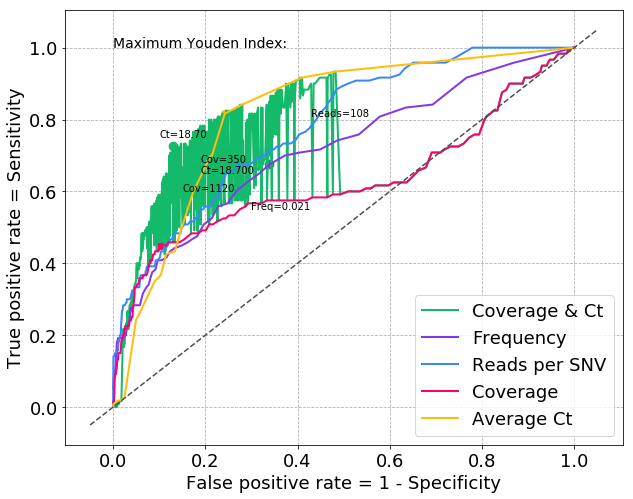

In [452]:
def plot_roc(freq_df, reads_df, cov_df, ct_df, cov_ct_df):
    '''
    Plots ROC curve
    '''
    youden_freq = freq_df['max_freq'][freq_df['youden'].idxmax()]
    youden_reads = reads_df['max_reads'][reads_df['youden'].idxmax()]
    youden_cov = cov_df['lowest_cov'][cov_df['youden'].idxmax()]
    youden_ct = ct_df['avg_ct'][ct_df['youden'].idxmax()]
    youden_combined_cov = cov_ct_df['lowest_cov'][cov_ct_df['youden'].idxmax()]
    youden_combined_ct = cov_ct_df['avg_ct'][cov_ct_df['youden'].idxmax()]
    
    
    mpl.rcParams.update({'font.size': 18})
    
    fig, ax1 = plt.subplots(figsize=(10,8))
    
    
    for df, col, label, in zip([cov_ct_df, freq_df, reads_df, cov_df, ct_df], ['#12BA69', '#8338EC', '#3A86FF','#FF006E','#FFBE0B'], ['Coverage & Ct', 'Frequency', 'Reads per SNV', 'Coverage', 'Average Ct']):
        #AUC = "{:.2f}".format(auc(df['fpr'], df['sensitivity']))
        sns.lineplot(data=df, x='fpr', y='sensitivity', ax=ax1, color=col, label=(label), linewidth=2)# + '; AUC=' + AUC), linewidth=2)
        youden_tpr = df['sensitivity'][df['youden'].idxmax()]
        youden_fpr = df['fpr'][df['youden'].idxmax()]
        ax1.scatter(x=youden_fpr, y=youden_tpr, color=col, s=75)
    ax1.set(ylabel='True positive rate = Sensitivity', xlabel = 'False positive rate = 1 - Specificity')
    ax1.plot(ax1.get_xlim(), ax1.get_ylim(), ls="--", c=".3")
    ax1.grid(linestyle='dashed')
    
    ax1.text(x=0, y=1, s='Maximum Youden Index:', fontsize=14)
    ax1.text(x=0.3, y=0.55, s='Freq={:.3f}'.format(youden_freq), fontsize=10)
    ax1.text(x=0.43, y=0.81, s='Reads={:.0f}'.format(youden_reads), fontsize=10)
    ax1.text(x=0.15, y=0.6, s='Cov={:.0f}'.format(youden_cov), fontsize=10)
    ax1.text(x=0.1, y=0.75, s='Ct={:.2f}'.format(youden_ct), fontsize=10)
    ax1.text(x=0.19, y=0.65, s = 'Ct={:.3f}'.format(youden_combined_ct), fontsize=10)
    ax1.text(x=0.19, y=0.68, s='Cov={:.0f}'.format(youden_combined_cov), fontsize=10)
    ax1.legend()
    
    return plt.show()

plot_roc(freq_df, reads_df, cov_df, ct_df, dedup_ct)#cov_freq_df[cov_freq_df['max_freq'] <= 0.05])

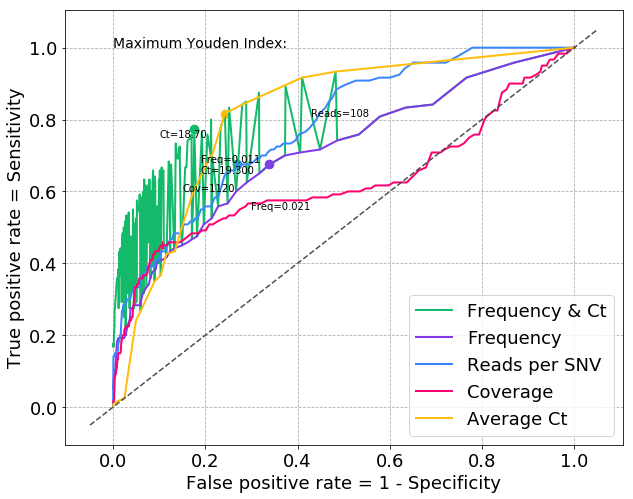

In [455]:
def plot_roc(freq_df, reads_df, cov_df, ct_df, freq_ct_df):
    '''
    Plots ROC curve
    '''
    youden_freq = freq_df['max_freq'][freq_df['youden'].idxmax()]
    youden_reads = reads_df['max_reads'][reads_df['youden'].idxmax()]
    youden_cov = cov_df['lowest_cov'][cov_df['youden'].idxmax()]
    youden_ct = ct_df['avg_ct'][ct_df['youden'].idxmax()]
    youden_combined_freq = freq_ct_df['max_freq'][freq_ct_df['youden'].idxmax()]
    youden_combined_ct = freq_ct_df['avg_ct'][freq_ct_df['youden'].idxmax()]
    
    
    mpl.rcParams.update({'font.size': 18})
    
    fig, ax1 = plt.subplots(figsize=(10,8))
    
    
    for df, col, label, in zip([freq_ct_df, freq_df, reads_df, cov_df, ct_df], ['#12BA69', '#8338EC', '#3A86FF','#FF006E','#FFBE0B'], ['Frequency & Ct', 'Frequency', 'Reads per SNV', 'Coverage', 'Average Ct']):
        #AUC = "{:.2f}".format(auc(df['fpr'], df['sensitivity']))
        sns.lineplot(data=df, x='fpr', y='sensitivity', ax=ax1, color=col, label=(label), linewidth=2)# + '; AUC=' + AUC), linewidth=2)
        youden_tpr = df['sensitivity'][df['youden'].idxmax()]
        youden_fpr = df['fpr'][df['youden'].idxmax()]
        ax1.scatter(x=youden_fpr, y=youden_tpr, color=col, s=75)
    ax1.set(ylabel='True positive rate = Sensitivity', xlabel = 'False positive rate = 1 - Specificity')
    ax1.plot(ax1.get_xlim(), ax1.get_ylim(), ls="--", c=".3")
    ax1.grid(linestyle='dashed')
    
    ax1.text(x=0, y=1, s='Maximum Youden Index:', fontsize=14)
    ax1.text(x=0.3, y=0.55, s='Freq={:.3f}'.format(youden_freq), fontsize=10)
    ax1.text(x=0.43, y=0.81, s='Reads={:.0f}'.format(youden_reads), fontsize=10)
    ax1.text(x=0.15, y=0.6, s='Cov={:.0f}'.format(youden_cov), fontsize=10)
    ax1.text(x=0.1, y=0.75, s='Ct={:.2f}'.format(youden_ct), fontsize=10)
    ax1.text(x=0.19, y=0.65, s = 'Ct={:.3f}'.format(youden_combined_ct), fontsize=10)
    ax1.text(x=0.19, y=0.68, s='Freq={:.3f}'.format(youden_combined_freq), fontsize=10)
    ax1.legend()
    
    return plt.show()

plot_roc(freq_df, reads_df, cov_df, ct_df, dedup_ct_freq)#cov_freq_df[cov_freq_df['max_freq'] <= 0.05])

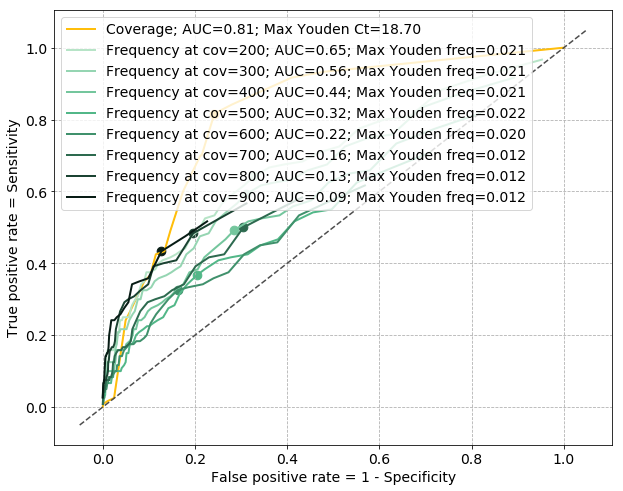

In [451]:
def plot_roc(ct_df, cov_freq_df):
    '''
    Plots ROC curve
    '''    
    mpl.rcParams.update({'font.size': 14})
    
    fig, ax1 = plt.subplots(figsize=(10,8))
    
    youden_ct = ct_df['avg_ct'][ct_df['youden'].idxmax()]
    AUC_ct = "{:.2f}".format(auc(ct_df['fpr'], ct_df['sensitivity']))
    sns.lineplot(data=ct_df, x='fpr', y='sensitivity', ax=ax1, color='#FFBE0B', label=('Coverage' + '; AUC=' + AUC_ct + '; Max Youden Ct=' + '{:.2f}'.format(youden_ct)), linewidth=2)
    youden_tpr_ct = ct_df['sensitivity'][ct_df['youden'].idxmax()]
    youden_fpr_ct = ct_df['fpr'][ct_df['youden'].idxmax()]
    ax1.scatter(x=youden_fpr_ct, y=youden_tpr_ct, color='#FFBE0B', s=75)
    #ax1.text(x=youden_fpr_ct, y=youden_tpr_ct, s='Ct={:.2f}'.format(youden_ct), fontsize=10)
    
    for cutoff, col, in zip(np.arange(200,1000,100), ['#B7E4C7', '#95D5B2','#74C69D','#52B788', '#40916C', '#2D6A4F', '#1B4332', '#081C15']):
        df = cov_freq_df[cov_freq_df['lowest_cov'] == cutoff]
        youden_freq = df['max_freq'][df['youden'].idxmax()]
        AUC = "{:.2f}".format(auc(df['fpr'], df['sensitivity']))
        sns.lineplot(data=df, x='fpr', y='sensitivity', ax=ax1, color=col, label=('Frequency at cov=' + str(cutoff) + '; AUC=' + AUC + '; Max Youden freq=' + '{:.3f}'.format(youden_freq)), linewidth=2)
        youden_tpr = df['sensitivity'][df['youden'].idxmax()]
        youden_fpr = df['fpr'][df['youden'].idxmax()]
        ax1.scatter(x=youden_fpr, y=youden_tpr, color=col, s=75)
        #ax1.text(x=youden_fpr, y=youden_tpr, s = 'Freq={:.3f}'.format(youden_freq), fontsize=10)
        
    ax1.set(ylabel='True positive rate = Sensitivity', xlabel = 'False positive rate = 1 - Specificity')
    ax1.plot(ax1.get_xlim(), ax1.get_ylim(), ls="--", c=".3")
    ax1.grid(linestyle='dashed')
    ax1.legend()
    #ax1.text(x=0, y=1.05, s='Maximum Youden Index:', fontsize=14)
    
    return plt.show()

plot_roc(ct_df, cov_freq_df)

## Quick and dirty: Is there a relationship between diversity and symptom onset?

In [390]:
def prepare_df(mDF, vDF):
    '''
    Filters to intersection SNPs and adds time since symptom onset for all.
    '''
    filtered = vDF[(vDF.type1 != 'None') & (vDF.type2 != 'None')]
    downsampled = filtered[['id1', 'id2', 'replicate_no', 'avg_ct']]
    samples = downsampled.drop_duplicates().copy()
    n_snvs = downsampled.value_counts(sort=False, subset=['replicate_no'])
    samples['n_snvs'] = list(n_snvs)
    samples = samples.reset_index().copy()
        
    mDF['date'] = pd.to_datetime(mDF['date'], format='%Y-%m-%d')
    mDF['symptom_onset'] = pd.to_datetime(mDF['symptom_onset'], format='%Y-%m-%d')
    
    for i, p in zip(['id1', 'id2'], ['post_symp1', 'post_symp2']):
        post_list = []
        for sample in samples[i]:
            date = mDF[mDF.id == sample]['date']
            sympon = mDF[mDF.id == sample]['symptom_onset']
            post_symp = date-sympon
            post_list.append(post_symp.values[0])
        samples[p] = post_list
    samples['post_symp'] = samples['post_symp1'].combine_first(samples['post_symp2'])

    return samples.drop(columns=['post_symp1', 'post_symp2'])

to_plot = prepare_df(metadata, variants)

/home/cwagner2/miniconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


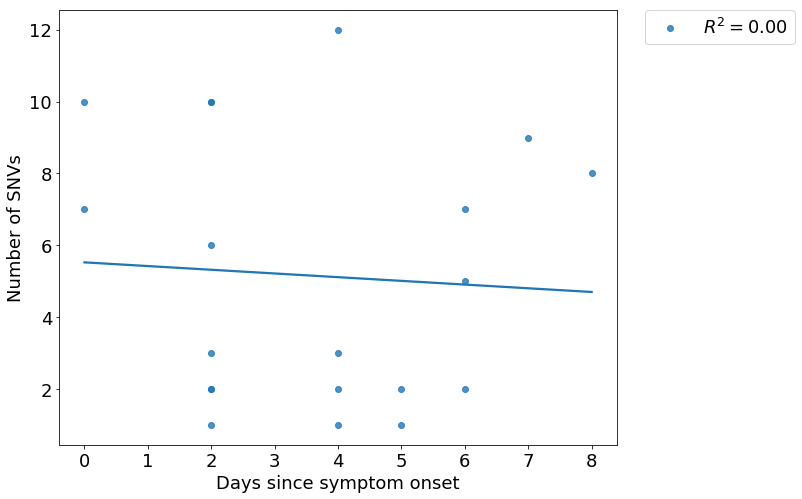

In [391]:
plottt = to_plot.dropna()

plottt['post_symp'] = plottt['post_symp'].dt.days

fig, ax = plt.subplots(figsize=(10,8))
slope, intercept, r_value, p_value, std_err = stats.linregress(plottt['post_symp'],plottt['n_snvs'])
sns.regplot(data=plottt[plottt['post_symp'] < 20], x='post_symp', y='n_snvs', ci=None, label=r'$R^2={0:.2f}$'.format(r_value**2), ax=ax)
ax.set(ylabel='Number of SNVs', xlabel='Days since symptom onset')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)






## Is there a relationship between variant frequency and days since symptom onset?

2020-12-09 00:00:00


/home/cwagner2/miniconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


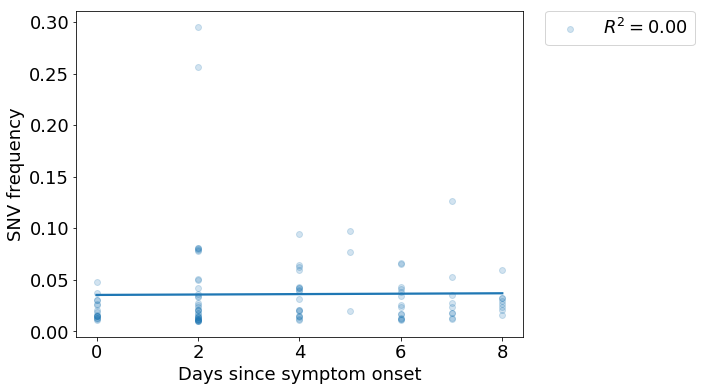

In [424]:
def prepare_df(mDF, vDF):
    '''
    Filters to intersection SNPs and adds time since symptom onset for all.
    '''
    filtered = vDF[(vDF.type1 != 'None') & (vDF.type2 != 'None')]
    filtered['avg_freq'] = (filtered['freq1'] + filtered['freq2'])/2
    
    mDF['date'] = pd.to_datetime(mDF['date'], format='%Y-%m-%d')
    print(mDF['date'].max())
    mDF['symptom_onset'] = pd.to_datetime(mDF['symptom_onset'], format='%Y-%m-%d')
    mDF['post_symp'] = mDF['date'] - mDF['symptom_onset']
    
    merged = filtered.merge(mDF[['id', 'post_symp']], how='left', left_on='id1', right_on='id')
    merged1 = merged.rename(columns={'post_symp':'post_symp1'})
    merged = merged1.merge(mDF[['id', 'post_symp']], how='left', left_on='id2', right_on='id')
    merged2 = merged.rename(columns={'post_symp':'post_symp2'})
    merged2['post_symp'] = merged2['post_symp1'].combine_first(merged2['post_symp2'])
    merged = merged2.drop(columns=['post_symp1', 'post_symp2'])
    return merged

to_plot = prepare_df(metadata, variants)
                           
to_plot = to_plot.dropna(subset=['post_symp'])
to_plot['post_symp'] = to_plot['post_symp'].dt.days
to_plot = to_plot[to_plot['post_symp'] < 20]

fig, ax = plt.subplots(figsize=(8,6))
slope, intercept, r_value, p_value, std_err = stats.linregress(to_plot['post_symp'],to_plot['avg_freq'])
sns.regplot(data=to_plot, x='post_symp', y='avg_freq', ci=None, label=r'$R^2={0:.2f}$'.format(r_value**2), ax=ax, scatter_kws={'alpha':0.2})
ax.set(ylabel='SNV frequency', xlabel='Days since symptom onset')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                           

## Is there a relationship between SNVs & age?

/home/cwagner2/miniconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


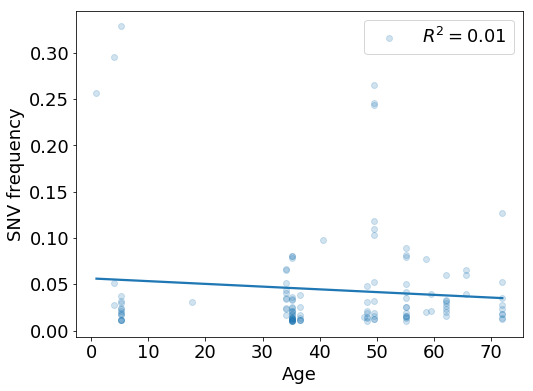

In [400]:
def prepare_df(mDF, vDF):
    '''
    Filters to intersection SNPs and adds time since symptom onset for all.
    '''
    filtered = vDF[(vDF.type1 != 'None') & (vDF.type2 != 'None')]
    filtered['avg_freq'] = (filtered['freq1'] + filtered['freq2'])/2
    
    merged = filtered.merge(mDF[['id', 'age']], how='left', left_on='id1', right_on='id')
    merged1 = merged.rename(columns={'age':'age1'})
    merged = merged1.merge(mDF[['id', 'age']], how='left', left_on='id2', right_on='id')
    merged2 = merged.rename(columns={'age':'age2'})
    merged2['age'] = merged2['age1'].combine_first(merged2['age2'])
    merged = merged2.drop(columns=['age1', 'age2'])
    return merged

to_plot = prepare_df(metadata, variants)
                           
to_plot = to_plot.dropna(subset=['age'])
#to_plot = to_plot[to_plot.avg_freq >= 0.05]

fig, ax = plt.subplots(figsize=(8,6))
slope, intercept, r_value, p_value, std_err = stats.linregress(to_plot['age'],to_plot['avg_freq'])
sns.regplot(data=to_plot, x='age', y='avg_freq', ci=None, label=r'$R^2={0:.2f}$'.format(r_value**2), ax=ax, scatter_kws={'alpha':0.2})
ax.set(ylabel='SNV frequency', xlabel='Age')
plt.legend()

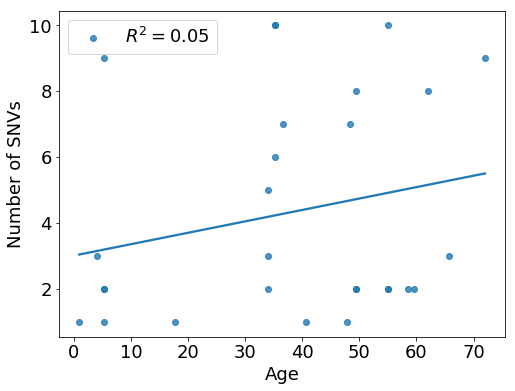

In [403]:
def prepare_df(mDF, vDF):
    '''
    Filters to intersection SNPs and adds time since symptom onset for all.
    '''
    filtered = vDF[(vDF.type1 != 'None') & (vDF.type2 != 'None')]
    downsampled = filtered[['id1', 'id2', 'replicate_no', 'avg_ct']]
    samples = downsampled.drop_duplicates().copy()
    n_snvs = downsampled.value_counts(sort=False, subset=['replicate_no'])
    samples['n_snvs'] = list(n_snvs)
    samples = samples.reset_index().copy()
    
    merged = samples.merge(mDF[['id', 'age']], how='left', left_on='id1', right_on='id')
    merged1 = merged.rename(columns={'age':'age1'})
    merged = merged1.merge(mDF[['id', 'age']], how='left', left_on='id2', right_on='id')
    merged2 = merged.rename(columns={'age':'age2'})
    merged2['age'] = merged2['age1'].combine_first(merged2['age2'])
    merged = merged2.drop(columns=['age1', 'age2'])

    return merged

to_plot = prepare_df(metadata, variants)
                           
to_plot = to_plot.dropna(subset=['age'])
#to_plot = to_plot[to_plot.avg_freq >= 0.05]

fig, ax = plt.subplots(figsize=(8,6))
slope, intercept, r_value, p_value, std_err = stats.linregress(to_plot['age'],to_plot['n_snvs'])
sns.regplot(data=to_plot, x='age', y='n_snvs', ci=None, label=r'$R^2={0:.2f}$'.format(r_value**2), ax=ax)
ax.set(ylabel='Number of SNVs', xlabel='Age')
plt.legend()


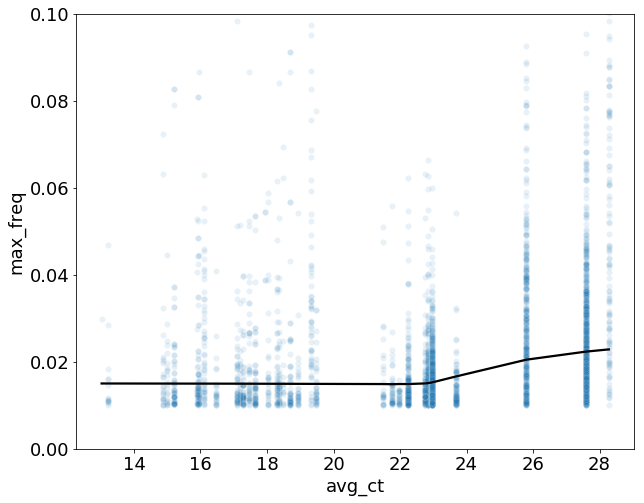

In [154]:
fig, ax = plt.subplots(figsize=(10,8))

sns.scatterplot(data=cleaned, x='avg_ct', y='max_freq', alpha=0.1, ax=ax)
ax.set_ylim([0,0.1])
sns.regplot(data=cleaned, x='avg_ct', y='max_freq', lowess=True, scatter=False, color='black')

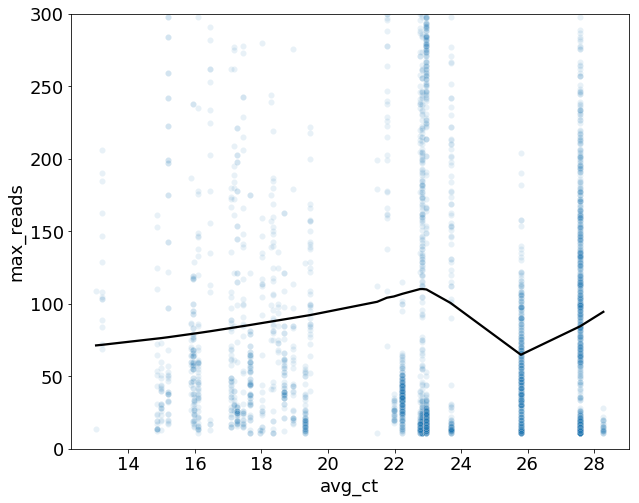

In [155]:
fig, ax = plt.subplots(figsize=(10,8))

sns.scatterplot(data=cleaned, x='avg_ct', y='max_reads', alpha=0.1, ax=ax)
ax.set_ylim([0,300])
#sns.regplot(data=cleaned, x='avg_ct', y='max_reads', scatter=False, color='black', fit_reg=True)
sns.regplot(data=cleaned, x='avg_ct', y='max_reads', scatter=False, color='black', lowess=True)


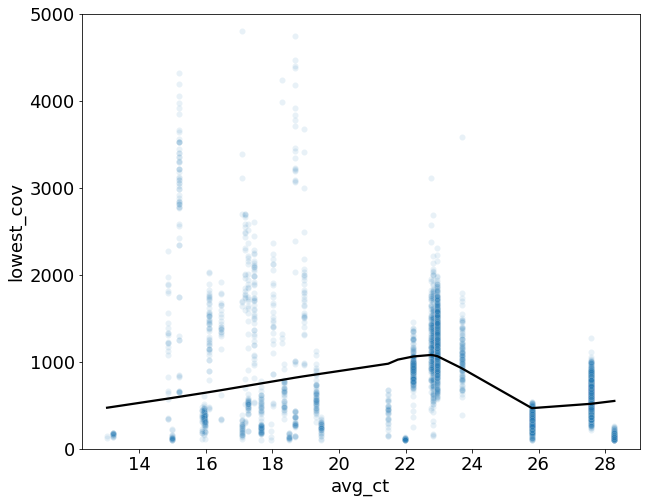

In [156]:
fig, ax = plt.subplots(figsize=(10,8))

sns.scatterplot(data=cleaned, x='avg_ct', y='lowest_cov', alpha=0.1, ax=ax)
ax.set_ylim([0,5000])
sns.regplot(data=cleaned, x='avg_ct', y='lowest_cov', lowess=True, scatter=False, color='black')

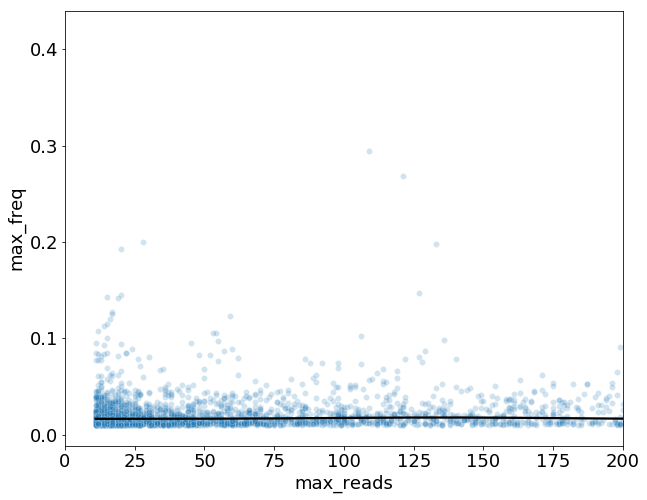

In [157]:
fig, ax = plt.subplots(figsize=(10,8))

sns.scatterplot(data=cleaned, x='max_reads', y='max_freq', ax=ax, alpha=0.2)
ax.set_xlim([0,200])
sns.regplot(data=cleaned, x='max_reads', y='max_freq', lowess=True, scatter=False, color='black')

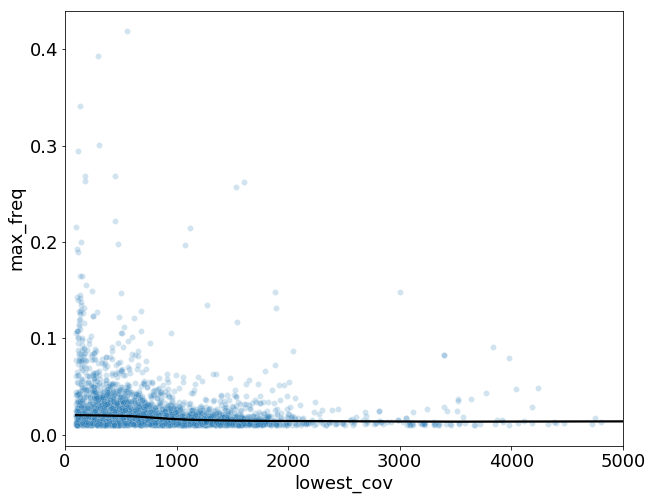

In [158]:
fig, ax = plt.subplots(figsize=(10,8))

sns.scatterplot(data=cleaned, x='lowest_cov', y='max_freq', ax=ax, alpha=0.2)
ax.set_xlim([0,5000])
sns.regplot(data=cleaned, x='lowest_cov', y='max_freq', lowess=True, scatter=False, color='black')

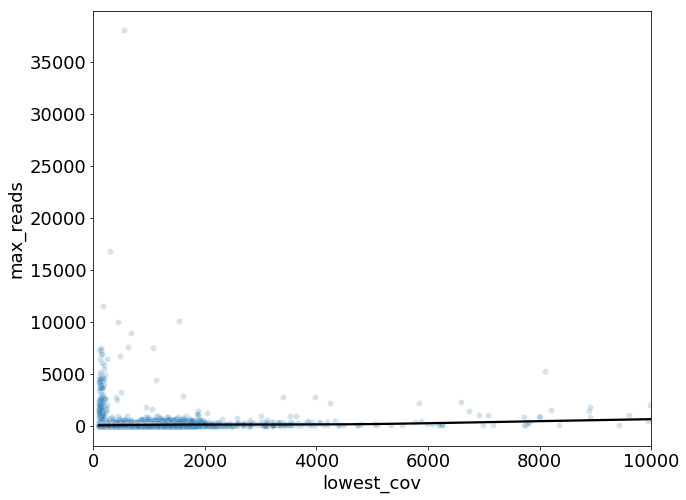

In [159]:
fig, ax = plt.subplots(figsize=(10,8))

sns.scatterplot(data=cleaned, x='lowest_cov', y='max_reads', ax=ax, alpha=0.2)
ax.set_xlim([0,10000])
sns.regplot(data=cleaned, x='lowest_cov', y='max_reads', lowess=True, scatter=False, color='black')